In [1]:
# IVF-PQ + exact L2 GT + (optional) refine/rerank
# Copy-paste ready

import time
import re
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple

import numpy as np
from tqdm.auto import tqdm
from sklearn.cluster import MiniBatchKMeans


# =========================
# Utils: pick artifact files
# =========================
def pick_paths(data_dir: Path, d: int):
    data_dir = data_dir.resolve()
    bases = sorted(data_dir.glob(f"glove{d}d_base_*__ds*.npz"))
    if not bases:
        raise FileNotFoundError(f"No base files for d={d} in {data_dir}")

    base_path = bases[-1]
    m = re.search(r"__ds([0-9a-f]{16})\.npz$", base_path.name)
    if not m:
        raise RuntimeError(f"Can't parse dataset_id from: {base_path.name}")
    ds = m.group(1)

    queries = sorted(data_dir.glob(f"glove{d}d_queries_*__ds{ds}.npz"))
    if not queries:
        raise FileNotFoundError(f"No queries for d={d}, ds={ds}")

    return base_path, queries[-1], ds


# =========================
# Exact GT for L2 (batched)
# =========================
def ground_truth_topk_l2(
    X: np.ndarray,
    Q: np.ndarray,
    k: int,
    exclude_ids: Optional[np.ndarray] = None,  # shape (nq,)
    x_batch: int = 5000,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Exact top-k nearest neighbors by L2 distance.
    Returns (gt_ids, gt_dists) with shapes (nq, k), sorted by ascending distance.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    Q = np.ascontiguousarray(Q, dtype=np.float32)
    nq = Q.shape[0]
    k = int(k)

    gt_ids = np.full((nq, k), -1, dtype=np.int32)
    gt_ds  = np.full((nq, k), np.inf, dtype=np.float32)

    q2 = np.sum(Q * Q, axis=1, keepdims=True)  # (nq,1)

    for start in tqdm(range(0, X.shape[0], x_batch), desc="GT L2 over X batches"):
        end = min(X.shape[0], start + x_batch)
        Xb = X[start:end]  # (b,d)
        x2 = np.sum(Xb * Xb, axis=1, keepdims=True).T  # (1,b)

        # dist = ||q||^2 + ||x||^2 - 2 q·x
        dist = q2 + x2 - 2.0 * (Q @ Xb.T)  # (nq,b)

        if exclude_ids is not None:
            ex = exclude_ids.astype(np.int64, copy=False)
            m = (ex >= start) & (ex < end)
            if np.any(m):
                rows = np.nonzero(m)[0]
                cols = (ex[m] - start).astype(np.int64, copy=False)
                dist[rows, cols] = np.inf

        b = dist.shape[1]
        kk = min(k, b)

        idx_local = np.argpartition(dist, kth=kk-1, axis=1)[:, :kk]  # smallest
        ds_local  = np.take_along_axis(dist, idx_local, axis=1)
        ids_local = (idx_local + start).astype(np.int32, copy=False)

        ids_merge = np.concatenate([gt_ids, ids_local], axis=1)
        ds_merge  = np.concatenate([gt_ds,  ds_local], axis=1)

        idx_keep = np.argpartition(ds_merge, kth=k-1, axis=1)[:, :k]
        ds_keep  = np.take_along_axis(ds_merge, idx_keep, axis=1)
        ids_keep = np.take_along_axis(ids_merge, idx_keep, axis=1)

        order = np.argsort(ds_keep, axis=1)
        gt_ds  = np.take_along_axis(ds_keep,  order, axis=1).astype(np.float32, copy=False)
        gt_ids = np.take_along_axis(ids_keep, order, axis=1).astype(np.int32, copy=False)

    return gt_ids, gt_ds


# =========================
# Metrics
# =========================
def overlap_at_k(gt_ids: np.ndarray, pred_ids: np.ndarray, k: int) -> float:
    """Your previous 'recall': average overlap/10."""
    gt_k = gt_ids[:, :k]
    pr_k = pred_ids[:, :k]
    s = 0
    for i in range(gt_k.shape[0]):
        s += len(set(gt_k[i]).intersection(set(pr_k[i])))
    return s / (gt_k.shape[0] * k)

def hit_at_k(gt_ids: np.ndarray, pred_ids: np.ndarray, k: int) -> float:
    """Hit@k: fraction of queries with at least 1 correct neighbor in top-k."""
    gt_k = gt_ids[:, :k]
    pr_k = pred_ids[:, :k]
    hits = 0
    for i in range(gt_k.shape[0]):
        if len(set(gt_k[i]).intersection(set(pr_k[i]))) > 0:
            hits += 1
    return hits / gt_k.shape[0]


def timed_search(fn, Q, k, warmup=1, runs=2):
    for _ in range(warmup):
        fn(Q, k)
    best = None
    best_out = None
    for _ in range(runs):
        t0 = time.perf_counter()
        out = fn(Q, k)
        t1 = time.perf_counter()
        ms_q = 1000.0 * (t1 - t0) / Q.shape[0]
        if best is None or ms_q < best:
            best = ms_q
            best_out = out
    return best, best_out


# =========================
# IVF-PQ (residual, L2 ADC) + refine/rerank
# =========================
@dataclass
class IVFPQ:
    d: int
    nlist: int = 2048
    nprobe: int = 16
    M: int = 20
    nbits: int = 8
    use_residual: bool = True
    random_state: int = 42

    centroids: Optional[np.ndarray] = None      # (nlist, d)
    codebooks: Optional[np.ndarray] = None      # (M, K, ds)
    list_ids: Optional[List[np.ndarray]] = None
    list_codes: Optional[List[np.ndarray]] = None

    X_store: Optional[np.ndarray] = None        # (N,d) for refine (ids == row index)

    def __post_init__(self):
        assert self.d % self.M == 0, "d must be divisible by M"
        assert self.nbits == 8, "nbits=8 only (uint8 codes)"
        self.ds = self.d // self.M
        self.K = 1 << self.nbits

    def train(self, X: np.ndarray):
        X = np.ascontiguousarray(X, dtype=np.float32)
        assert X.shape[1] == self.d

        km = MiniBatchKMeans(
            n_clusters=self.nlist,
            batch_size=8192,
            random_state=self.random_state,
            n_init=3,
        )
        labels = km.fit_predict(X)
        self.centroids = km.cluster_centers_.astype(np.float32)

        if self.use_residual:
            R = X - self.centroids[labels]
        else:
            R = X

        Rb = R.reshape(-1, self.M, self.ds)

        codebooks = np.empty((self.M, self.K, self.ds), dtype=np.float32)
        for m in tqdm(range(self.M), desc=f"Train PQ codebooks (M={self.M})"):
            km_m = MiniBatchKMeans(
                n_clusters=self.K,
                batch_size=8192,
                random_state=self.random_state + 1000 + m,
                n_init=3,
            )
            km_m.fit(Rb[:, m, :])
            codebooks[m] = km_m.cluster_centers_.astype(np.float32)
        self.codebooks = codebooks

        self.list_ids = [np.empty((0,), dtype=np.int64) for _ in range(self.nlist)]
        self.list_codes = [np.empty((0, self.M), dtype=np.uint8) for _ in range(self.nlist)]

    def _assign_lists_l2(self, X: np.ndarray) -> np.ndarray:
        C = self.centroids
        x2 = np.sum(X * X, axis=1, keepdims=True)
        c2 = np.sum(C * C, axis=1, keepdims=True).T
        dist = x2 + c2 - 2.0 * (X @ C.T)
        return np.argmin(dist, axis=1).astype(np.int32)

    def _pq_encode(self, R: np.ndarray) -> np.ndarray:
        Rb = R.reshape(-1, self.M, self.ds)
        codes = np.empty((Rb.shape[0], self.M), dtype=np.uint8)
        for m in range(self.M):
            W = self.codebooks[m]  # (K,ds)
            r2 = np.sum(Rb[:, m, :] * Rb[:, m, :], axis=1, keepdims=True)
            w2 = np.sum(W * W, axis=1, keepdims=True).T
            dist = r2 + w2 - 2.0 * (Rb[:, m, :] @ W.T)
            codes[:, m] = np.argmin(dist, axis=1).astype(np.uint8)
        return codes

    def add(self, X: np.ndarray, ids: Optional[np.ndarray] = None):
        X = np.ascontiguousarray(X, dtype=np.float32)
        N = X.shape[0]
        if ids is None:
            ids = np.arange(N, dtype=np.int64)
        else:
            ids = np.ascontiguousarray(ids, dtype=np.int64)
            assert ids.shape[0] == N

        # keep base for refine (assumes ids == row index)
        self.X_store = X

        labels = self._assign_lists_l2(X)
        if self.use_residual:
            R = X - self.centroids[labels]
        else:
            R = X
        codes = self._pq_encode(R)

        for l in range(self.nlist):
            mask = (labels == l)
            if not np.any(mask):
                continue
            self.list_ids[l] = np.concatenate([self.list_ids[l], ids[mask]])
            self.list_codes[l] = np.concatenate([self.list_codes[l], codes[mask]], axis=0)

    def _topnprobe_lists_l2(self, Q: np.ndarray) -> np.ndarray:
        C = self.centroids
        q2 = np.sum(Q * Q, axis=1, keepdims=True)
        c2 = np.sum(C * C, axis=1, keepdims=True).T
        dist = q2 + c2 - 2.0 * (Q @ C.T)
        return np.argpartition(dist, kth=self.nprobe - 1, axis=1)[:, :self.nprobe]

    def _lookup_table(self, q_res: np.ndarray) -> np.ndarray:
        qb = q_res.reshape(self.M, self.ds)
        T = np.empty((self.M, self.K), dtype=np.float32)
        for m in range(self.M):
            W = self.codebooks[m]
            diff = W - qb[m][None, :]
            T[m] = np.sum(diff * diff, axis=1)
        return T

    def search(self, Q: np.ndarray, k: int = 10, refine_r: int = 0) -> Tuple[np.ndarray, np.ndarray]:
        """
        refine_r:
          0   -> return PQ top-k
          >k  -> take top refine_r by PQ, then rerank by exact L2 using X_store, then return exact top-k
        """
        Q = np.ascontiguousarray(Q, dtype=np.float32)
        nq = Q.shape[0]
        I = np.full((nq, k), -1, dtype=np.int64)
        D = np.full((nq, k), np.inf, dtype=np.float32)

        probe_lists = self._topnprobe_lists_l2(Q)

        for i in range(nq):
            q = Q[i]
            cand_ids = []
            cand_dist = []

            for l in probe_lists[i]:
                l = int(l)
                ids_l = self.list_ids[l]
                codes_l = self.list_codes[l]
                if ids_l.size == 0:
                    continue

                q_res = q - self.centroids[l] if self.use_residual else q
                T = self._lookup_table(q_res)

                dist_l = np.zeros((codes_l.shape[0],), dtype=np.float32)
                for m in range(self.M):
                    dist_l += T[m, codes_l[:, m]]

                cand_ids.append(ids_l)
                cand_dist.append(dist_l)

            if not cand_ids:
                continue

            cand_ids = np.concatenate(cand_ids)
            cand_dist = np.concatenate(cand_dist)

            # how many candidates to keep before final top-k selection
            if refine_r and refine_r > k:
                R = min(int(refine_r), cand_dist.size)
            else:
                R = min(k, cand_dist.size)

            topR = np.argpartition(cand_dist, kth=R-1)[:R]
            idsR = cand_ids[topR]
            distR = cand_dist[topR]

            if refine_r and refine_r > 0:
                if self.X_store is None:
                    raise RuntimeError("X_store is None. Call add(X) before search() with refine.")
                # exact L2
                Xc = self.X_store[idsR.astype(np.int64, copy=False)]
                diff = Xc - q[None, :]
                dist_exact = np.sum(diff * diff, axis=1)

                kk = min(k, dist_exact.size)
                sel = np.argpartition(dist_exact, kth=kk-1)[:kk]
                idsK = idsR[sel]
                dK = dist_exact[sel]
                order = np.argsort(dK)
                I[i, :kk] = idsK[order]
                D[i, :kk] = dK[order]
            else:
                kk = min(k, distR.size)
                sel = np.argpartition(distR, kth=kk-1)[:kk]
                idsK = idsR[sel]
                dK = distR[sel]
                order = np.argsort(dK)
                I[i, :kk] = idsK[order]
                D[i, :kk] = dK[order]

        return I, D


# =========================
# Experiment runner: all dims
# =========================
DATA_DIR = Path("./artifacts/data").resolve()  # <-- поправь под себя
DIMS = [50, 100, 200, 300]

# Eval settings
TOPK_GT = 50          # GT top-K (exact)
K_EVAL = 10           # report @10
NPROBE_GRID = [4, 8, 16, 32, 64]  # add 64 for better recall

# Speed knobs
NQ_EVAL = 2000        # enough for stable estimates
X_BATCH_GT = 5000

# Refine (rerank) knob: biggest easy recall boost
REFINE_R = 500        # try 200 / 500 / 1000


def choose_M(d: int) -> int:
    """
    Prefer ds=4 when possible (often better PQ quality),
    fallback to sensible divisors.
    """
    if d == 50:  return 25  # ds=2 (often better than ds=5)
    if d == 100: return 25  # ds=4
    if d == 200: return 50  # ds=4
    if d == 300: return 75  # ds=4
    for M in [96, 80, 75, 64, 60, 50, 48, 40, 32, 25, 20, 16, 10]:
        if d % M == 0:
            return M
    raise ValueError("No suitable M")


results = []

for d in DIMS:
    base_path, queries_path, ds = pick_paths(DATA_DIR, d)
    print("\n==============================")
    print(f"d={d}, ds={ds}")
    print("base   :", base_path.name)
    print("queries:", queries_path.name)

    base = np.load(base_path, allow_pickle=True)
    queries = np.load(queries_path, allow_pickle=True)

    Xn_full = np.ascontiguousarray(base["Xn"], dtype=np.float32)        # (N,d) unit vecs
    q_idx_test = np.ascontiguousarray(queries["q_idx_test"], dtype=np.int64)
    Qn_test_full = np.ascontiguousarray(queries["Qn_test"], dtype=np.float32)

    nq_full = Qn_test_full.shape[0]
    nq = min(NQ_EVAL, nq_full)
    Qn_test = Qn_test_full[:nq]
    exclude_ids = q_idx_test[:nq]  # queries are subset of base; exclude self in GT

    # 1) Exact GT by L2
    print("Computing exact GT (L2)...")
    t0 = time.perf_counter()
    gt_ids_l2, _ = ground_truth_topk_l2(
        Xn_full, Qn_test, k=TOPK_GT, exclude_ids=exclude_ids, x_batch=X_BATCH_GT
    )
    t1 = time.perf_counter()
    print(f"GT L2 time: {t1-t0:.2f}s")

    # 2) Train IVF-PQ
    M = choose_M(d)
    index = IVFPQ(d=d, nlist=2048, nprobe=16, M=M, nbits=8, use_residual=True)

    print(f"Training IVF-PQ (nlist={index.nlist}, M={M}, ds={d//M})...")
    t0 = time.perf_counter()
    index.train(Xn_full)
    t1 = time.perf_counter()
    print(f"train time: {t1-t0:.2f}s")

    print("Adding...")
    t0 = time.perf_counter()
    index.add(Xn_full, ids=np.arange(Xn_full.shape[0], dtype=np.int64))
    t1 = time.perf_counter()
    print(f"add time: {t1-t0:.2f}s")

    def search_fn(Q, k):
        return index.search(Q, k, refine_r=REFINE_R)

    # 3) Sweep nprobe
    for nprobe in NPROBE_GRID:
        index.nprobe = nprobe
        ms_q, (I, _) = timed_search(search_fn, Qn_test, K_EVAL, warmup=1, runs=2)

        ov = overlap_at_k(gt_ids_l2, I, K_EVAL)   # your previous recall-like metric
        ht = hit_at_k(gt_ids_l2, I, K_EVAL)       # what many call "recall@10"

        row = {
            "ds": ds, "d": d, "M": M, "nlist": index.nlist, "nprobe": nprobe,
            "overlap@10": float(ov),
            "hit@10": float(ht),
            "ms/query": float(ms_q),
            "QPS": float(1000.0 / ms_q),
            "refine_r": int(REFINE_R),
        }
        results.append(row)
        print(row)

# Summary
print("\n\n===== SUMMARY =====")
for d in DIMS:
    rows = [r for r in results if r["d"] == d]
    if not rows:
        continue
    rows = sorted(rows, key=lambda r: r["nprobe"])
    print(f"\nd={d} (M={rows[0]['M']}, nlist={rows[0]['nlist']}, ds={rows[0]['ds']}, refine_r={rows[0]['refine_r']})")
    for r in rows:
        print(
            f"  nprobe={r['nprobe']:>3}  overlap@10={r['overlap@10']:.4f}  hit@10={r['hit@10']:.4f}  "
            f"ms/q={r['ms/query']:.3f}  QPS={r['QPS']:.1f}"
        )



d=50, ds=989456bc6cc2e6ed
base   : glove50d_base_N400000__ds989456bc6cc2e6ed.npz
queries: glove50d_queries_N400000_nq100000_test20000_seed42__ds989456bc6cc2e6ed.npz
Computing exact GT (L2)...


GT L2 over X batches:   0%|          | 0/80 [00:00<?, ?it/s]

GT L2 time: 12.59s
Training IVF-PQ (nlist=2048, M=25, ds=2)...


Train PQ codebooks (M=25):   0%|          | 0/25 [00:00<?, ?it/s]

train time: 67.65s
Adding...
add time: 17.95s
{'ds': '989456bc6cc2e6ed', 'd': 50, 'M': 25, 'nlist': 2048, 'nprobe': 4, 'overlap@10': 0.57765, 'hit@10': 0.9815, 'ms/query': 0.8577913330000014, 'QPS': 1165.7846862390697, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 50, 'M': 25, 'nlist': 2048, 'nprobe': 8, 'overlap@10': 0.68065, 'hit@10': 0.997, 'ms/query': 1.605114854, 'QPS': 623.00837694447, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 50, 'M': 25, 'nlist': 2048, 'nprobe': 16, 'overlap@10': 0.76805, 'hit@10': 0.9995, 'ms/query': 2.9789740829999976, 'QPS': 335.68603557401303, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 50, 'M': 25, 'nlist': 2048, 'nprobe': 32, 'overlap@10': 0.8389, 'hit@10': 1.0, 'ms/query': 5.746629812500004, 'QPS': 174.01503709614485, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 50, 'M': 25, 'nlist': 2048, 'nprobe': 64, 'overlap@10': 0.87855, 'hit@10': 1.0, 'ms/query': 11.500191312500007, 'QPS': 86.95507516584189, 'refine_r': 500}

d=100, ds=989456bc6c

GT L2 over X batches:   0%|          | 0/80 [00:00<?, ?it/s]

GT L2 time: 12.70s
Training IVF-PQ (nlist=2048, M=25, ds=4)...


Train PQ codebooks (M=25):   0%|          | 0/25 [00:00<?, ?it/s]

train time: 99.86s
Adding...
add time: 16.72s
{'ds': '989456bc6cc2e6ed', 'd': 100, 'M': 25, 'nlist': 2048, 'nprobe': 4, 'overlap@10': 0.6342, 'hit@10': 0.976, 'ms/query': 0.9636783750000006, 'QPS': 1037.6906091723802, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 100, 'M': 25, 'nlist': 2048, 'nprobe': 8, 'overlap@10': 0.73355, 'hit@10': 0.9945, 'ms/query': 1.867203187499996, 'QPS': 535.560353953178, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 100, 'M': 25, 'nlist': 2048, 'nprobe': 16, 'overlap@10': 0.80665, 'hit@10': 0.9985, 'ms/query': 3.3665088960000276, 'QPS': 297.04362319914446, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 100, 'M': 25, 'nlist': 2048, 'nprobe': 32, 'overlap@10': 0.85585, 'hit@10': 1.0, 'ms/query': 6.532754374999996, 'QPS': 153.0747893762653, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 100, 'M': 25, 'nlist': 2048, 'nprobe': 64, 'overlap@10': 0.8848, 'hit@10': 1.0, 'ms/query': 12.888062791499976, 'QPS': 77.5911800072488, 'refine_r': 500}

d=200, ds=9

GT L2 over X batches:   0%|          | 0/80 [00:00<?, ?it/s]

GT L2 time: 13.04s
Training IVF-PQ (nlist=2048, M=50, ds=4)...


Train PQ codebooks (M=50):   0%|          | 0/50 [00:00<?, ?it/s]

train time: 206.34s
Adding...
add time: 27.10s
{'ds': '989456bc6cc2e6ed', 'd': 200, 'M': 50, 'nlist': 2048, 'nprobe': 4, 'overlap@10': 0.609, 'hit@10': 0.9725, 'ms/query': 1.8848463334999792, 'QPS': 530.5472293558785, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 200, 'M': 50, 'nlist': 2048, 'nprobe': 8, 'overlap@10': 0.69525, 'hit@10': 0.9945, 'ms/query': 3.716031104000024, 'QPS': 269.1043137188966, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 200, 'M': 50, 'nlist': 2048, 'nprobe': 16, 'overlap@10': 0.7639, 'hit@10': 0.998, 'ms/query': 7.05648114600001, 'QPS': 141.71369260539345, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 200, 'M': 50, 'nlist': 2048, 'nprobe': 32, 'overlap@10': 0.8244, 'hit@10': 1.0, 'ms/query': 13.961105229499992, 'QPS': 71.62756698423756, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 200, 'M': 50, 'nlist': 2048, 'nprobe': 64, 'overlap@10': 0.8667, 'hit@10': 1.0, 'ms/query': 27.144129604499994, 'QPS': 36.84037818012107, 'refine_r': 500}

d=300, ds=989

GT L2 over X batches:   0%|          | 0/80 [00:00<?, ?it/s]

GT L2 time: 13.94s
Training IVF-PQ (nlist=2048, M=75, ds=4)...


Train PQ codebooks (M=75):   0%|          | 0/75 [00:00<?, ?it/s]

train time: 256.49s
Adding...
add time: 39.52s
{'ds': '989456bc6cc2e6ed', 'd': 300, 'M': 75, 'nlist': 2048, 'nprobe': 4, 'overlap@10': 0.64525, 'hit@10': 0.982, 'ms/query': 7.122660166500054, 'QPS': 140.3969832371466, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 300, 'M': 75, 'nlist': 2048, 'nprobe': 8, 'overlap@10': 0.7512, 'hit@10': 0.995, 'ms/query': 13.865612478999992, 'QPS': 72.12086747084118, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 300, 'M': 75, 'nlist': 2048, 'nprobe': 16, 'overlap@10': 0.8417, 'hit@10': 1.0, 'ms/query': 28.667957312499997, 'QPS': 34.88215044760002, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 300, 'M': 75, 'nlist': 2048, 'nprobe': 32, 'overlap@10': 0.8865, 'hit@10': 1.0, 'ms/query': 57.25537200000007, 'QPS': 17.465610039176738, 'refine_r': 500}
{'ds': '989456bc6cc2e6ed', 'd': 300, 'M': 75, 'nlist': 2048, 'nprobe': 64, 'overlap@10': 0.89965, 'hit@10': 1.0, 'ms/query': 93.93289508349994, 'QPS': 10.645897788107863, 'refine_r': 500}


===== SUMMARY

Dims: [50, 100, 200, 300]
nprobe grid: [4, 8, 16, 32, 64]


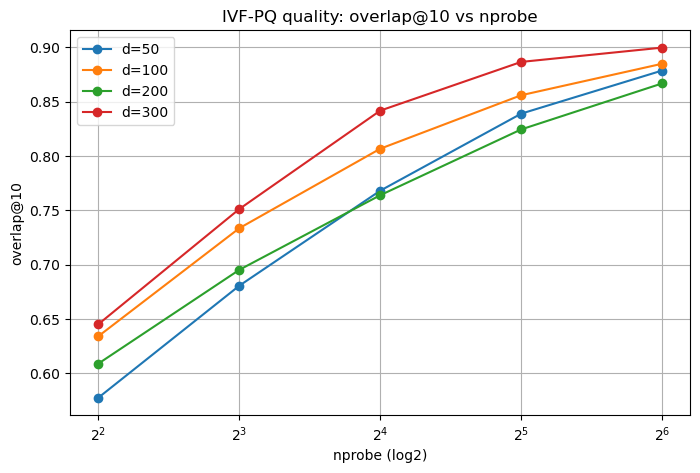

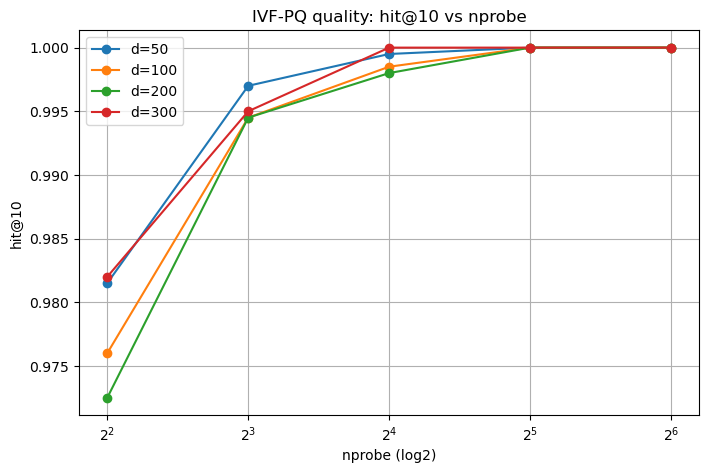

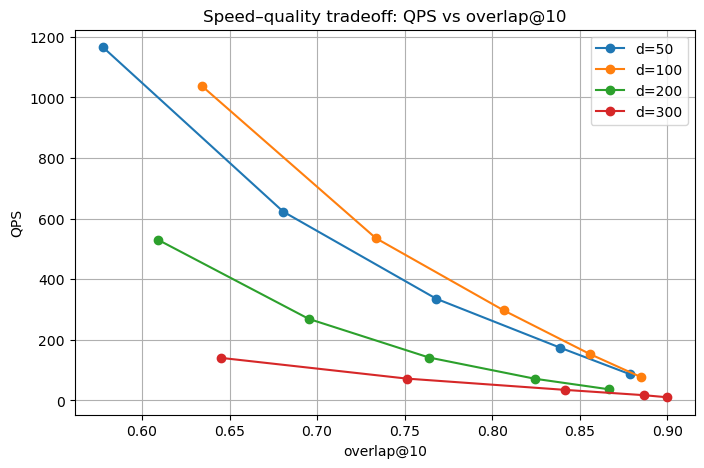

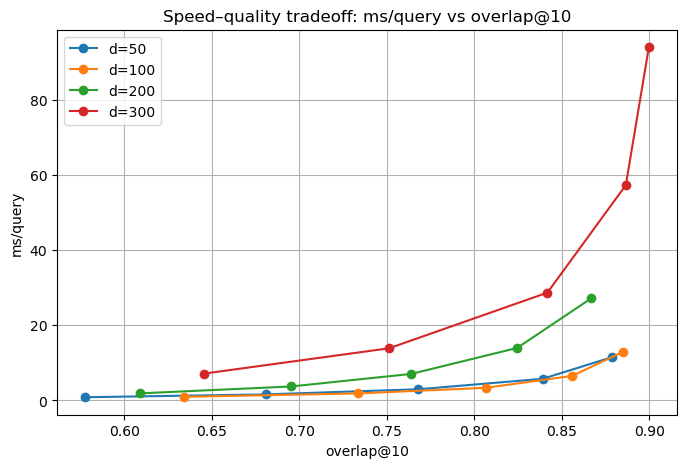

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# results = [...] уже посчитан выше

def uniq_sorted(xs):
    return sorted(set(xs))

dims = uniq_sorted([r["d"] for r in results])
nprobes = uniq_sorted([r["nprobe"] for r in results])

print("Dims:", dims)
print("nprobe grid:", nprobes)

def rows_for_dim(d):
    rows = [r for r in results if r["d"] == d]
    rows = sorted(rows, key=lambda r: r["nprobe"])
    return rows

def plot_vs_nprobe(metric_key, ylabel, title):
    plt.figure(figsize=(8, 5))
    for d in dims:
        rows = rows_for_dim(d)
        x = [r["nprobe"] for r in rows]
        y = [r[metric_key] for r in rows]
        plt.plot(x, y, marker="o", label=f"d={d}")
    plt.xscale("log", base=2)
    plt.xlabel("nprobe (log2)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_vs_nprobe("overlap@10", "overlap@10", "IVF-PQ quality: overlap@10 vs nprobe")
plot_vs_nprobe("hit@10", "hit@10", "IVF-PQ quality: hit@10 vs nprobe")

# Tradeoff: QPS vs overlap@10
plt.figure(figsize=(8, 5))
for d in dims:
    rows = rows_for_dim(d)
    x = [r["overlap@10"] for r in rows]
    y = [r["QPS"] for r in rows]
    plt.plot(x, y, marker="o", label=f"d={d}")
plt.xlabel("overlap@10")
plt.ylabel("QPS")
plt.title("Speed–quality tradeoff: QPS vs overlap@10")
plt.grid(True)
plt.legend()
plt.show()

# Tradeoff: ms/query vs overlap@10
plt.figure(figsize=(8, 5))
for d in dims:
    rows = rows_for_dim(d)
    x = [r["overlap@10"] for r in rows]
    y = [r["ms/query"] for r in rows]
    plt.plot(x, y, marker="o", label=f"d={d}")
plt.xlabel("overlap@10")
plt.ylabel("ms/query")
plt.title("Speed–quality tradeoff: ms/query vs overlap@10")
plt.grid(True)
plt.legend()
plt.show()
